# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='Great question, Lance! Ocean mammals are a fascinating group of animals. Here are a few more ocean mammals you might want to learn about:\n\n1. **Dolphins**: These intelligent and social creatures are known for their playful behavior and complex communication skills. There are several species of dolphins, including the bottlenose dolphin and the common dolphin.\n\n2. **Porpoises**: Similar to dolphins but typically smaller and stouter, porpoises are less well-known but equally interesting. The harbor porpoise is one example.\n\n3. **Seals**: These include both true seals (like the harbor seal) and eared seals (which include sea lions and fur seals). They are known for their ability to live both in the water and on land.\n\n4. **Sea Lions**: These are a type of eared seal, easily recognized by their external ear flaps and their ability to "walk" on land using their large flippers.\n\n5. **Walruses**: Known for their distinctive long tusks and whiskers, walruses are so

We can run our chat model in a simple graph with `MessagesState`.

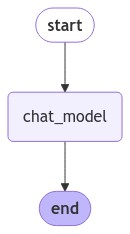

In [5]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Absolutely, whales are fascinating! But there are many other ocean mammals worth learning about. Here are a few you might find interesting:

1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful behavior and complex communication. There are many species, including the bottlenose dolphin and the orca (killer whale), which is actually the largest member of the dolphin family.

2. **Seals and Sea Lions**: These pinnipeds are often found lounging on beaches or frolicking in the water. Seals tend to be more solitary, while sea lions are social and known for their barking calls.

3. **Man

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

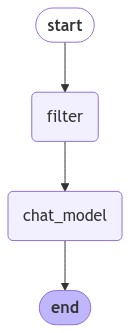

In [ ]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are a variety of other fascinating ocean mammals you might be interested in learning about. Here are a few:

1. **Dolphins**: These highly intelligent and social animals are part of the cetacean family, which also includes whales and porpoises. There are many species of dolphins, including the common bottlenose dolphin and the orca, or killer whale, which is actually the largest member of the dolphin family.

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures and teeth. The harbor porpoise is one of the more well-known sp

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

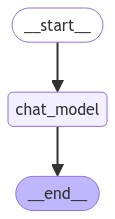

In [ ]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [ ]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [ ]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

In [ ]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

The state has all of the mesages.

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens for the llm. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

- `max_tokens` is the no of token allowed for output, only 100 tokens are used
- `strategy` is where and how we should apply trimming, most recent and final message in the list is it is `last`
- `token_count` is the method used to define what a token is for the mentioned llm
- `allow_partial` cutting messages in the middle if max token size is reached

See the `trim_messages` below.

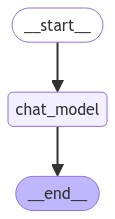

In [ ]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [ ]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', name='Lance')]

In [ ]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

### --- Experimenting ---

In [11]:
import os
from dotenv import load_dotenv
load_dotenv()
CHAT_MODEL=os.getenv("CHAT_MODEL")

In [15]:
from langgraph.graph import MessagesState, START, END, StateGraph
from langchain_core.messages import HumanMessage, AIMessage, RemoveMessage
from langchain_groq import ChatGroq


In [12]:
llm = ChatGroq(model=CHAT_MODEL)

In [17]:
def filter_node(state:MessagesState):
    recent_messages = [RemoveMessage(m.key) for m in state['messages'][:-2]]
    return {'messages':recent_messages}

In [18]:
def chat_node(state: MessagesState):
    return {'messages': llm.invoke(state['messages'])}

In [19]:
builder = StateGraph(MessagesState)

builder.add_node('filter', filter_node)
builder.add_node('chat', chat_node)

builder.add_edge(START, 'filter')
builder.add_edge('filter', 'chat')
builder.add_edge('chat', END)

graph=builder.compile()

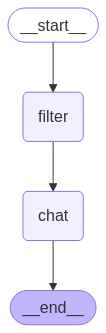

In [20]:
graph

In [23]:
messages=[HumanMessage(content="Hey, this is mark",name='mark')]
messages.append(AIMessage(content="Hi Mark, its great to meet you.", name="AI"))
messages.append(HumanMessage(content="Please tell me a few coffee recepies", name='mark'))
messages.append(AIMessage(content="Sure, Caffè Latte, Cappuccino, Mocha, Flat White", name="AI"))

response = graph.invoke({'messages':"Please tell me which is the lightest."})

In [24]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Please tell me which is the lightest.
================================== Ai Message ==================================

<think>
Okay, so I need to figure out which of these three things is the lightest. The options are a feather, a small rock, and a paperclip. Hmm, let's start by thinking about each one individually.

First, a feather. I know feathers are really light because birds use them to fly, and flight requires being as light as possible. Feathers are made of light materials, so I'm guessing they don't weigh much at all. Maybe just a few grams?

Next, a small rock. Rocks vary in weight depending on their size and type, but a small one, like maybe the size of a pebble, could be a bit heavier than a feather. I've picked up small rocks before, and they have some heft to them, but they're not super heavy. Maybe around 5-10 grams?

Then there's the paperclip. Paperclips are made of metal, usually steel 